## Project Summary: AI-Powered Car Tracking System Using YOLOv8
This project aims to create the prototype of a system that tracks traffic on italian highway roads.
## Main components
- **Flask** for the webapp
- **YOLOv8** for cars segmentation and tracking
- **OpenCV** for video editing
- **FFMPEG** for video codec management
- **Pandas** for dataframe management
- **autostrade.it** as the source of webcam videos

## Basic Idea
Google maps implements a live traffic detection system based on device tracking data. Although Google's system is very efficient, it may be cause for issues due to bad maps or bad traffic data that can lead to wrong traffic redirections, as happened for the A22 highway last May ([Article](https://www.ilpost.it/2024/05/31/code-alto-adige-vipiteno-brennero-a22-errore-google-maps/)).

The italian highway company Autostrade Per L'Italia (ASPI) has a freely accessible website with the feeds from live traffic webcams scattered in every road under its jurisdiction. These videos could be implemented into a live traffic detection system and this is what the project aims to do.

## Project structure

```
root
├── data
    ├── cameras.csv
    └── datacollection.csv
├── static
    ├── favicon.ico
    └── ...
├── templates
    ├── index.html
    └── camera_index_dashboard.html
├── app.py
├── dataCollect_routine.py
├── cron_file
├── Dockerfile
├── requirements.txt
└── yolov8m-seg.pt
```
- The folder /data holds all the csvs needed:
  - /data/cameras.csv contains the detailed list of cameras used by the project
  - /data/datacollect.csv contains the list of each traffic detection made by the script /dataCollect_routine.py
- Although the /static folder is called "static", it holds every media the website may need to display, including the very dynamic videos shown in  dashboards.
- The /templates folder contains each html template written using the Jinja2 syntax for dynamic content.
- /app.py is the entry point of the flask webapp.
- /dataCollect_routine.py is the script called to update videos and data.
- /cron_file contains the instructions for the cronjob for the timed execution of dataCollect_routine.py.
- /Dockerfile contains the instructions for building the docker image.
- /requirements.txt contains all the pip packages required.
- /yolov8m-seg.pt contains the weights for the yolo model used.

## Failed attempts
For the tracking task there were many approaches possible and, before settling for yolov8 pretrained model, other attempts were made.
- OpenCV object tracking was the first method tried, but due to the videos being low resolution, it was unable to correctly track cars present in the frames.
- Another attempt was made to create a custom model using frames extracted from the videos ([link to roboflow project](https://universe.roboflow.com/learningprojects-t0pqh/aspitrafficanalyzer)), but the pretrained model still outperformed the custom one on unseen videos.
- Another failed attempt was the one regarding the computation of car velocities by which two horizontal lines were added to the videos and cars were timed passing the first and the second, but due to a lack of precision in models, there were frames in which cars were not detected.

## Implemented solution
The solution implemented uses the tracking feature from YOLO which is able to detect and identify cars through the videos, making it possible to also track cars directions and speeds.

## Possible future improvements of the developed solution
- Due to low-res videos and cars dimensions in the frames, it may happen that yolo doesn't correctly detect cars systematically among each very different road camera feed. This issue could be fixed by mixing and matching different detection methods at the expense of computation times.
- At the time being, speeds are expressed in pixels/time. This is due to the fact that there is no systematic way to figure space measurements out of the videos since the only unit, the dashed centerlines, are not reliable.
- As of now, webapp dashboards only show raw data. This could be improved by computing more stats and even using the data taken to build a road traffic dataset and predict traffic.

In [37]:
!pip install ultralytics
from ultralytics import YOLO
# Load a YOLOv8m model
model_m = YOLO('yolov8m-seg.pt')

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 39, in create_package_set_from_installed
    for dist in env.iter_installed_distributions(lo

In [47]:
import cv2
from datetime import datetime
video_path = 'input.mp4'
cap = cv2.VideoCapture(video_path)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [48]:
# Save to file the processed video
processed_video_path = 'out.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(processed_video_path, fourcc, fps, (width, height))

In [4]:
# Define the detection window
y1 = 140
y2 = height - 40
x1 = 0
x2 = width

In [23]:
# Define the dict in which the detections will be saved
from collections import defaultdict
track_history = defaultdict(lambda: {"points": [], "direction": [0,0], "speeds": []})

In [40]:
# Calculate stats function
def calculate_stats(trackhistory):
    count_up = 0
    count_down = 0
    sum_speed_up = 0
    sum_speed_down = 0
    for _,v in trackhistory.items():
        try:
          average_speed = sum(v["speeds"])/float(len(v["speeds"]))
        except:
          continue

        if v["direction"][0]>0:
            count_up += 1
            sum_speed_up += average_speed
        else:
            count_down += 1
            sum_speed_down += average_speed
    avg_speed_up = 0 if count_up == 0 else sum_speed_up/count_up
    avg_speed_down = 0 if count_down == 0 else sum_speed_down/count_down
    return (count_up, count_down, avg_speed_up, avg_speed_down)

In [49]:
import numpy as np
import csv
# Loop through the video frames
frame_count = 0
csv_filename = 'log.csv'
csv_headers_collection = ["date", "cars_up", "cars_down", "avg_speed_up", "avg_speed_down", "codCam"]
csv_headers_hist = ["frame", "track_id", "x", "y", "direction", "speeds"]
with open(csv_filename, "w") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers_hist)
    writer.writeheader()
while cap.isOpened():
    # Read a frame from the video
    success, original_frame = cap.read()
    if not success:
        if frame_count == 0:
            print('Video not found')
        else:
            print('Video terminated')
        break

    frame_count += 1

    try:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model_m.track(original_frame, persist=True, conf=0.2)
        try:
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            # Process and save track data to CSV
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]

                cv2.circle(original_frame, (int(x),int(y)), 1, (0, 0, 255), -1)
                if y < y1:
                    cv2.rectangle(original_frame, (int(x - w/2), int(y - h/2)), (int(x + w/2), int(y + h/2)), (0, 255, 0), 2)
                    cv2.putText(original_frame, f"ID {track_id}", (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    print("skipped")
                    continue
                cv2.rectangle(original_frame, (int(x - w/2), int(y - h/2)), (int(x + w/2), int(y + h/2)), (0, 153, 254), 2)
                cv2.putText(original_frame, f"ID {track_id}", (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 153, 254), 2)
                # Append center point and detect direction based on Y change
                new_point = (float(x), float(y))
                #print(new_point, track_id)
                if len(track["points"]) > 0:
                    previous_point = track["points"][-1]
                    print(previous_point, "->", new_point)
                    # Calculate distance travelled in pixels
                    distance = np.linalg.norm(np.array(new_point) - np.array(previous_point))
                    print(distance)
                    # Assuming constant frame rate (e.g., 30fps), estimate speed in pixels/frame
                    speed = distance if frame_count > 1 else 0  # Avoid division by zero
                    track_history[track_id]["speeds"].append(speed)
                    track_history[track_id]["direction"][0] = track_history[track_id]["direction"][0] + 1 if new_point[1] < previous_point[1] else track_history[track_id]["direction"][0] - 1
                    track_history[track_id]["direction"][1] = track_history[track_id]["direction"][1] + 1 if new_point[0] > previous_point[0] else track_history[track_id]["direction"][1] - 1
                track_history[track_id]["points"].append(new_point)
                print(f"Frame {frame_count}, Track ID {track_id}: {new_point}, Speed: {track_history[track_id]['speeds'][-1]} pixels/frame")
                # Save track data to CSV
                try:
                  with open(csv_filename, "a", newline = '', ) as csvfile:
                      writer = csv.DictWriter(csvfile, fieldnames=csv_headers_hist)
                      writer.writerow(
                          {
                              "frame": frame_count,
                              "track_id": track_id,
                              "x": new_point[0],
                              "y": new_point[1],
                              "direction": track_history[track_id]["direction"],
                              "speeds": track_history[track_id]["speeds"][-1]
                          }
                      )
                except Exception as e:
                  print("nothing added to hist\n", e)
                # Keep track history limited
                if len(track["points"]) > 30:
                    track["points"].pop(0)
        except:
            print('no cars found')
    except:
        print('div by zero error')
    cv2.rectangle(original_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,255), 2)
    out.write(original_frame)
count_up, count_down, avg_speed_up, avg_speed_down = calculate_stats(track_history)
with open('datacollection.csv', "a", newline = '', ) as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_headers_collection)
    writer.writerow(
        {
            "date": timestamp,
            "cars_up": count_up,
            "cars_down": count_down,
            "avg_speed_up": avg_speed_up,
            "avg_speed_down": avg_speed_down,
            "codCam": 1
        }
    )
    # Get the boxes and track IDs
# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


0: 544x640 1 train, 1 truck, 42.8ms
Speed: 3.4ms preprocess, 42.8ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 bus, 1 truck, 42.7ms
Speed: 3.0ms preprocess, 42.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 truck, 38.4ms
Speed: 2.8ms preprocess, 38.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 car, 1 truck, 37.0ms
Speed: 2.9ms preprocess, 37.0ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 car, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 car, 36.9ms
Speed: 2.3ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x640 1 car, 22.8ms
Speed: 2.5ms preprocess, 22.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)
no cars found

0: 544x64

Below is the processed video. The yellow rectangle is the actual detection window, as close as possible to where cars are more visible and detectable. Cars are detected from anywhere in the picture, but only the ones in the yellow rectangle, those that display an orange ID, are registered.

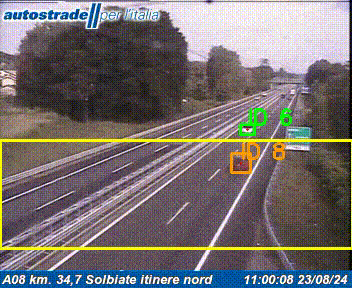

In [51]:
!cat log.csv

frame,track_id,x,y,direction,speeds
26,25,221.915283203125,176.9559783935547,"[13, 13]",41.19243102193107
27,25,224.92294311523438,173.94900512695312,"[14, 14]",4.252987934730857
27,26,157.190185546875,196.8618621826172,"[14, 14]",77.00783282127185
28,25,228.47406005859375,170.66012573242188,"[15, 15]",4.840161073475373
28,26,164.21795654296875,192.467529296875,"[15, 15]",8.28852982646813
29,25,230.37034606933594,168.2376708984375,"[16, 16]",3.076392051938567
29,26,171.369384765625,189.4251708984375,"[16, 16]",7.771671007469855
30,25,233.073486328125,162.7955322265625,"[17, 17]",6.076499039957431
30,26,177.16311645507812,183.91592407226562,"[17, 17]",7.9949438697878445
31,25,235.22772216796875,160.0697479248047,"[18, 18]",3.474281524772659
31,26,181.69656372070312,179.69839477539062,"[18, 18]",6.191905803563368
32,25,237.17010498046875,158.67413330078125,"[19, 19]",2.3917757355328053
32,26,186.3741455078125,175.32464599609375,"[19, 19]",6.403862097164354
33,25,238.96640014648438,157.31

In [50]:
track_history

defaultdict(<function __main__.<lambda>()>,
            {25: {'points': [(221.915283203125, 176.9559783935547),
               (224.92294311523438, 173.94900512695312),
               (228.47406005859375, 170.66012573242188),
               (230.37034606933594, 168.2376708984375),
               (233.073486328125, 162.7955322265625),
               (235.22772216796875, 160.0697479248047),
               (237.17010498046875, 158.67413330078125),
               (238.96640014648438, 157.317626953125),
               (240.46771240234375, 155.770751953125),
               (241.0718231201172, 154.13851928710938),
               (243.11834716796875, 153.65219116210938),
               (245.02175903320312, 151.858642578125),
               (246.76968383789062, 149.40133666992188),
               (247.93246459960938, 147.37152099609375),
               (248.81448364257812, 145.759033203125),
               (221.915283203125, 176.9559783935547),
               (224.92294311523438, 173.9490051269

In [53]:
!cat datacollection.csv

date,cars_up,cars_down,avg_speed_up,avg_speed_down,codCam
2024-08-24_05-59-09,18,9,5.086621650864398,7.6160016871452285,1
